## Linear Regression

矢量计算更快

In [2]:
import torch
import time

# init variable a, b as 1000 dimension vector
n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

In [4]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.02793 sec'

In [5]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00000 sec'

#### 手动实现linear regression

In [6]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.1.0


生成训练数据

In [7]:
# set input feature number 
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

图像显示

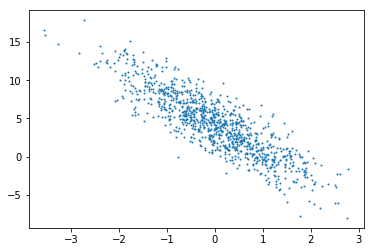

In [8]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

读取数据集

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5740,  0.1788],
        [-1.5210,  1.2714],
        [ 0.6628, -2.3555],
        [-1.1709,  0.2947],
        [ 0.2349,  1.0104],
        [ 0.4657,  0.4921],
        [ 1.0406,  2.0828],
        [-0.6625, -1.1706],
        [ 1.2177,  0.5809],
        [ 2.4422, -0.2562]]) 
 tensor([ 4.7586, -3.1695, 13.5267,  0.8616,  1.2248,  3.4673, -0.8007,  6.8450,
         4.6479,  9.9372])


In [11]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [12]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

In [25]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(-1, 1)) ** 2 / 2

In [26]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

In [27]:
# super parameters init
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050


In [29]:
w, true_w, b, true_b

(tensor([[ 2.0005],
         [-3.4004]], requires_grad=True),
 [2, -3.4],
 tensor([4.2002], requires_grad=True),
 4.2)

#### pytorch实现linear regression

In [30]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.1.0


In [31]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [32]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [33]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.5324, -1.0434],
        [-0.3712, -1.2315],
        [ 2.4761,  0.8055],
        [-0.9416, -0.2004],
        [-0.2680, -1.2775],
        [ 1.9070,  0.3582],
        [ 0.7403,  0.7043],
        [ 0.3735,  0.7448],
        [ 0.6946, -1.1991],
        [ 0.7959,  0.9288]]) 
 tensor([6.6871, 7.6308, 6.4215, 2.9869, 8.0259, 6.8013, 3.2740, 2.4183, 9.6655,
        2.6317])


In [34]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [35]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [36]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [37]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [38]:
loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

In [39]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [40]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000454
epoch 2, loss: 0.000076
epoch 3, loss: 0.000120


In [41]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0004, -3.3993]])
4.2 tensor([4.2006])
